# Propagação de incertezas


In [1]:
using Plots
using Distributions
using Random
using LsqFit
using Statistics

## Introdução

* Dado um modelo $y=f(\boldsymbol\beta, \mathbf{x})$, onde $\beta$ indica um vetor de parâmetros do modelo e $x$ um vetor de variáveis independentes, buscamos estimar as incertezas em $y$ em termos de incertezas em $\boldsymbol\beta$ e em $\mathbf{x}$.

* De maneira análoga, podemos buscar entender quão sensível a resposta $y$ é a  variações em $\boldsymbol\beta$ e em $\mathbf x$.

* No último caderno, vimos isso no caso de um modelo linear $y=\beta_0 + \beta_1 x$ e de incertezas na escolha dos parâmetros $\beta_0$ e $\beta_1$.

* Vamos, agora, explorar mais um pouco essa questão.

* Podemos, naturalmente, considerar um modelo vetorial, $\mathbf{y} = \mathbf{f}(\boldsymbol\beta, \mathbf{x})$. Mas, em muitos casos, essa análise, pode ser reduzida ao caso escalar, coordenada a coordenada. Para simplificar, vamos considerar apenas o caso escalar.

## Incertezas

* Nessa quantificação de incertezas, ou de análise de sensibilidade, tanto os parâmetros $\boldsymbol\beta$ como as variáveis independentes $\mathbf x$ são consideradas variáveis aleatórias.

* Vamos denotar as incertezas nessas quantidades por $\delta\boldsymbol\beta$ e $\delta\mathbf x$.

* Ou, em coordenadas específicas, $\delta\beta_j$ e $\delta x_i$.

## Propagação de incertezas em modelos lineares

* Vamos começar com um modelo linear afim
$$ y = \beta_0 + \beta_1 x_1 + \ldots + \beta_m x_m = \boldsymbol\beta \mathbf{x},
$$
onde $\boldsymbol\beta = (\beta_0, \beta_1, \ldots, \beta_m)$ e $\mathbf{x} = (1, x_1, \ldots, x_m)$.

* Este é um modelo em $m$-dimensões, com $m+1$ parâmetros. Apenas uma ligeira extensão do caso visto anteriormente.

* Nesse caso, a propagação em relação aos parâmetros é como antes:
$$ \delta y = \delta\beta_0 + \delta\beta_1 x_1 + \ldots + \delta\beta_m x_m = (\delta \boldsymbol\beta) \mathbf{x}.
$$

* Escrevendo $x_0 = 1$ para facilitar a notação, a variância de $y$ é como antes:
$$ \operatorname{Var}(y) = E((\delta y)^2) = E\left(((\delta \boldsymbol\beta) \mathbf{x})^2\right) = E\left(\left(\sum_{j=0}^m (\delta\beta_j) x_j\right)^2\right) =  E\left(\sum_{i,j=0}^m (\delta\beta_i)(\delta\beta_j)x_ix_j\right) \\ = \sum_{i,j=0}^m E((\delta\beta_i)(\delta\beta_j))x_ix_j =  \mathbf{x}^T \operatorname{Cov}(\delta\boldsymbol\beta)\mathbf{x}.
$$

## Propagação de incertezas em modelos não lineares

### Propagação local de incertezas via linearização

* Para variações pequenas, em modelos não-lineares, podemos linearizar o modelo.

* No caso $y = f(\boldsymbol\beta, \mathbf{x})$,
$$\delta y = f(\hat{\boldsymbol\beta} + \delta\boldsymbol\beta,\mathbf{x}) - f(\hat{\boldsymbol\beta}) \approx \nabla_{\boldsymbol\beta} f(\hat{\boldsymbol\beta}, \mathbf{x}) (\delta\boldsymbol\beta).
$$

* Com a linearização,
$$ \operatorname{Var}(y) = \nabla_{\boldsymbol\beta} f(\hat{\boldsymbol\beta}, \mathbf{x})^T\operatorname{Cov}(\delta\boldsymbol\beta) \nabla_{\boldsymbol\beta} f(\hat{\boldsymbol\beta}, \mathbf{x})
$$


### Propagação global

* Há uma série de métodos globais, como [Morris *one-at-a-time* (OTA)](https://en.wikipedia.org/wiki/Morris_method), [Sobol/Variância (ANOVA)](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis), [Fourier Amplitude Sensitivity Testing (FAST)](https://en.wikipedia.org/wiki/Fourier_amplitude_sensitivity_testing) e [Quasi-Monte Carlo](https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method).

* Aqui, no entanto, vamos considerar apenas o [método de Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) clássico.

* Neste método, geramos aleatoriamente uma amostra de parâmetros, segundo uma determinada distribuição, aplicamos o modelo e calculamos as estatísticas do resultado (e.g. média e intervalos de confiança).

## Exemplo de reação enzimática

* Neste exemplo, vamos usar aproximação local por derivação para estimar o erro nos parâmetros.

* E vamos usar propagação global via método de Monte-Carlo para estimar o erro no modelo a partir dos erros locais nos parâmetros.

* O exemplo é o mesmo exemplo de reação enzimática feito no caderno sobre otimização não-linear.

### Definindo os parâmetros da reação original

In [2]:
function model(t, β)
    ν_m = β[1]
    K_M = β[2]
    v = (ν_m .* t) ./ (K_M .+ t)
    return v
end

ν_m = 0.3
K_M = 0.5
β = [ν_m K_M]
nothing

### Colhendo amostra e visualizando os dados

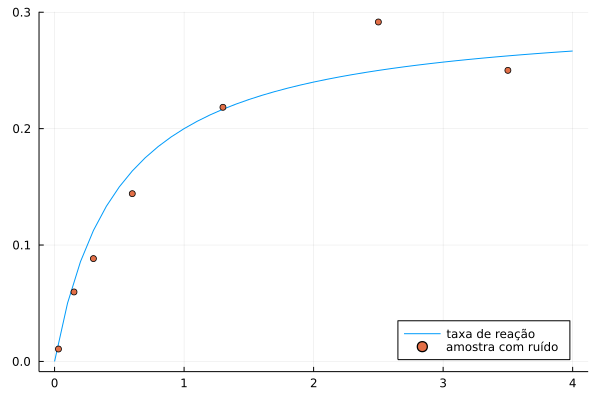

In [3]:
data_t = [0.03, 0.15, 0.3, 0.6, 1.3, 2.5, 3.5]

data_v = model(data_t, β) .+ 0.02*randn(MersenneTwister(503), length(data_t))
t = 0:0.1:4
plot(t, t -> model(t, β), label="taxa de reação", legend=:bottomright)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")

### Ajustando os parâmetros via `LsqFit`

In [4]:
β₀ = [0.5, 0.5]
fit = curve_fit(model, data_t, data_v, β₀)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.33783348970227, 0.7526693327934532], [0.002287858467353694, -0.00353906947255183, 0.007927265930608968, 0.005723230500666643, -0.004370304010094139, -0.031951447851221615, 0.02798044147826334], [0.03833036346635541 -0.01654502087870273; 0.16617380756132893 -0.06219229486267413; … ; 0.7685994929725614 -0.07982940235732612; 0.8230124954716369 -0.06538039091892706], true, Float64[])

### Estatísticas do ajuste

* Abaixo, obtemos

    * os parâmetros ajustados;

    * o erro padrão;

    * a margem de 95% de erro;

    * o intervalo de 95% de confiança;

    * a matriz variância-covariância.

In [5]:
β_fit = fit.param

2-element Vector{Float64}:
 0.33783348970227
 0.7526693327934532

In [6]:
σ = stderror(fit)

2-element Vector{Float64}:
 0.029934302313086008
 0.19558628728243857

In [7]:
margin_of_error = margin_error(fit, 0.05)

2-element Vector{Float64}:
 0.076948573788465
 0.5027705573877824

In [8]:
confidence_inter = confidence_interval(fit, 0.05)

2-element Vector{Tuple{Float64, Float64}}:
 (0.260884915913805, 0.414782063490735)
 (0.24989877540567074, 1.2554398901812356)

In [9]:
covar = estimate_covar(fit)

2×2 Matrix{Float64}:
 0.000896062  0.00517513
 0.00517513   0.038254

### Observações

* O erro padrão é a raiz quadrada dos elementos da diagonal da matriz de variância-covariância.

* A matriz de variância-covariância é obtida via aproximação local, a partir da matriz jacobiana e do erro quadrático médio ajustado pelo número de parâmetros.

In [10]:
sqrt.([covar[1,1],covar[2,2]])

2-element Vector{Float64}:
 0.029934302313086008
 0.19558628728243857

In [11]:
jac = fit.jacobian

7×2 Matrix{Float64}:
 0.0383304  -0.016545
 0.166174   -0.0621923
 0.28499    -0.0914619
 0.443567   -0.110782
 0.633322   -0.104234
 0.768599   -0.0798294
 0.823012   -0.0653804

In [12]:
mse(fit) * inv(jac' * jac)

2×2 Matrix{Float64}:
 0.000896062  0.00517513
 0.00517513   0.038254

### Observações

* Vale ressaltar que o erro quadrático médio `mse()` calculado pelo `LsqFit.jl` leva em consideração o grau de liberdade do modelo, dividindo por $N - p$, onde $N$ é o número de dados e $p$ é o número de parâmetros

* Esse ajuste é adequado para uma estimativa apropriada do erro padrão.

In [13]:
mse(fit)

0.0003872511807690088

In [14]:
length(data_v), length(β_fit)

(7, 2)

In [15]:
sum(abs2, data_v - model(data_t, β_fit)) / (length(data_v) - length(β_fit))

0.0003872511807690088

### Amostragem dos parâmetros

* Pelo método de Monte Carlo, fazemos uma amostragem nos parâmetros e observamos as estatísticas do resultado do modelo com esses parâmetros.

* Como os parâmetros estão correlacionados, usamos uma normal bidimensional, com a matriz de variância-covariância fornecida pelo método de otimização.

* Observe a seguir a diferença entre fazer a amostragem levando em consideração ou não a correlação entre os parâmetros.

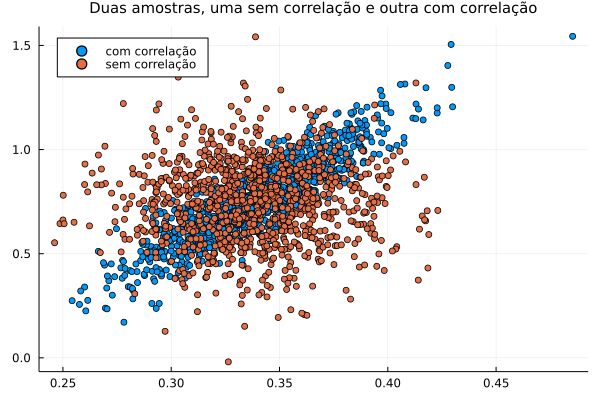

In [16]:
num_amostras = 1000
plot(title="Duas amostras, uma sem correlação e outra com correlação", titlefont=10)
scatter!((r -> (r[1,:], r[2,:]))(rand(MersenneTwister(13000), MvNormal(β_fit,covar), num_amostras)), label="com correlação")
scatter!((rand(Normal(β_fit[1],σ[1]),num_amostras),
        rand(Normal(β_fit[2],σ[2]),num_amostras)), label="sem correlação",
        legend=:topleft)

### Resultado da propagação de erro via Método de Monte Carlo

* Usando a amostragem considerando a correlação entre parâmetros, fazemos diversas simulações.

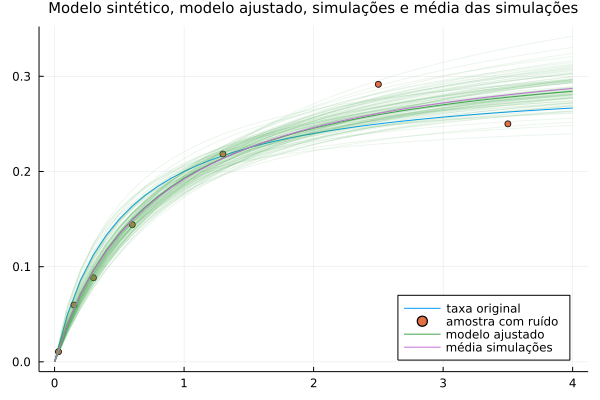

In [17]:
t = 0:0.1:4
num_amostras = 100
simulations = fill(0.0, length(t), num_amostras)
plot(t, t -> model(t, β), label="taxa original", legend=:bottomright,
    title="Modelo sintético, modelo ajustado, simulações e média das simulações", titlefont=10)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(t, t -> model(t, β_fit), label="modelo ajustado", legend=:bottomright)

for (n,β̃) in enumerate(eachcol(rand(MersenneTwister(13000), MvNormal(β_fit,covar), num_amostras)))
    modelagem = model.(t,Ref(β̃))
    simulations[:,n] = model.(t,Ref(β̃))
    plot!(t, simulations[:,n], label=false, alpha=0.1 , legend=:bottomright, color=3)
end
plot!(t, mean(simulations, dims=2), color=4, label="média simulações")

### Intervalo de confiança

* Nesse caso, o resultado da simulação em tempos diferentes não é mais independente do tempo.

* O próprio modelo leva a uma correlação entre os resultados das simulações em tempos diferentes.

* Por esse motivo, não podemos apelar para o Teorema do Limite Central para definir o intervalo de confiança.

* Os intervalos de confiança devem ser obtidos diretamente através dos percentis das simulações.

* Dessa forma, é natural que os intervalos de confiança não sejam simétricos em relação à média.

* De qualquer forma, vamos fazer, abaixo, dos dois jeitos, para efeito de comparação.

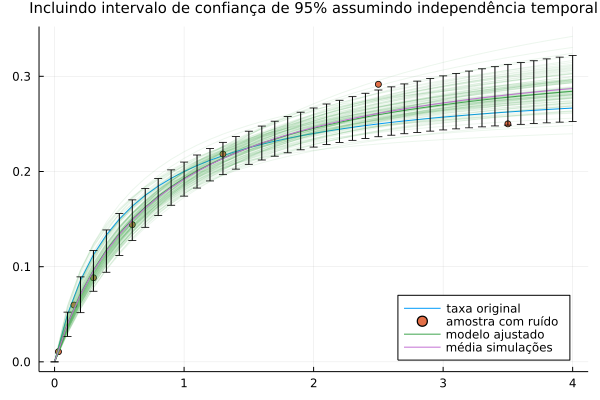

In [18]:
plot(t, t -> model(t, β), label="taxa original", legend=:bottomright,
    title="Incluindo intervalo de confiança de 95% assumindo independência temporal", titlefont=10)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(t, t -> model(t, β_fit), label="modelo ajustado", legend=:bottomright)

for n in 1:num_amostras
    plot!(t, simulations[:,n], label=false, alpha=0.1 , legend=:bottomright, color=3)
end
plot!(t, mean(simulations, dims=2), yerror=2*sqrt.(var(simulations, dims=2)), color=4,
    label="média simulações")

* Calculando os percentis a partir dos dados das simulações.

In [19]:
quantiles95 =
    reduce(vcat, [quantile(simulations[i,:], [0.025 0.975]) for i in 1:length(t)])

errorbar95 = quantiles95 .- mean(simulations, dims=2)

41×2 Matrix{Float64}:
  0.0         0.0
 -0.00911759  0.016708
 -0.0138763   0.0244809
 -0.0162127   0.0268753
 -0.0171647   0.0263309
 -0.0174861   0.0252796
 -0.0173037   0.0235826
 -0.0172024   0.0221576
 -0.0169754   0.0199883
 -0.0166392   0.0180607
  ⋮           
 -0.0292301   0.0297784
 -0.0298128   0.0305654
 -0.0303718   0.0313236
 -0.0309084   0.0320544
 -0.0314239   0.0327592
 -0.0319195   0.0334393
 -0.0323963   0.0340959
 -0.0328554   0.0347302
 -0.0332977   0.0353432

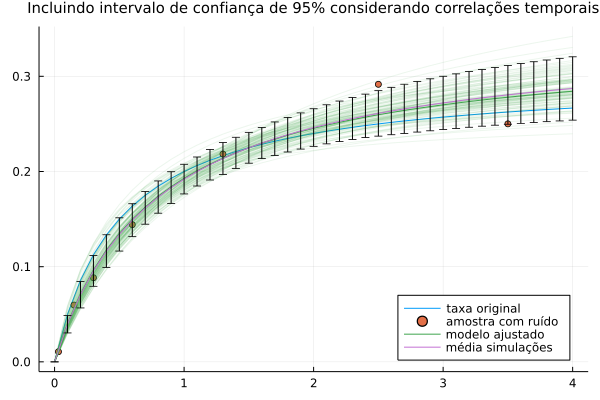

In [20]:
plot(t, t -> model(t, β), label="taxa original", legend=:bottomright,
    title="Incluindo intervalo de confiança de 95% considerando correlações temporais", titlefont=10)
plot!(data_t, data_v, seriestype=:scatter, label="amostra com ruído")
plot!(t, t -> model(t, β_fit), label="modelo ajustado", legend=:bottomright)
for n in 1:num_amostras
    plot!(t, simulations[:,n], label=false, alpha=0.1 , legend=:bottomright, color=3)
end
plot!(t, mean(simulations, dims=2), yerror=errorbar95, color=4,
    label="média simulações")

* Comparando os dois intervalos de confiança.

* Nesse exemplo, a diferença não foi considerável. Mas em outras situações, pode ser.

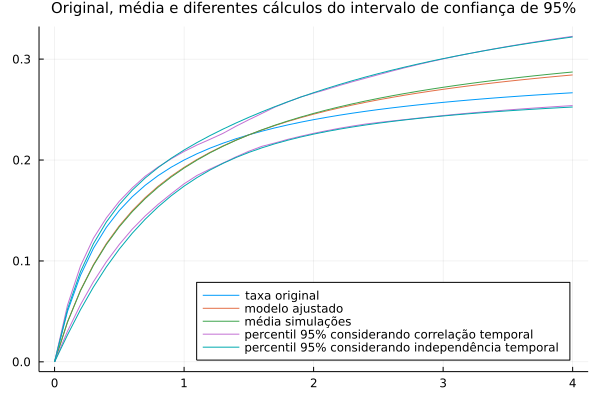

In [21]:
plot(t, t -> model(t, β), label="taxa original", legend=:bottomright,
    title="Original, média e diferentes cálculos do intervalo de confiança de 95%", titlefont=10)
plot!(t, t -> model(t, β_fit), color=2, label="modelo ajustado")
plot!(t, mean(simulations, dims=2), color=3, label="média simulações")
plot!(t, quantiles95, color=4, label=["percentil 95% considerando correlação temporal" nothing])
plot!(t, mean(simulations, dims=2) .+ 2*sqrt.(var(simulations, dims=2)), color=6,
    label="percentil 95% considerando independência temporal")
plot!(t, mean(simulations, dims=2) .- 2*sqrt.(var(simulations, dims=2)), color=6,
    label=nothing)

## Exercícios

1. Refaça os exemplos do caderno sobre **Modelos redutíveis ao caso linear nos parâmetros e aplicações** como problemas de otimização não-linear e faça as estatísticas de cada um deles, como feito acima.

1. Compare os intervalo de confiança obtidos no exercício acima com os intervalos de confiança obtidos no caderno anterior, sobre **Mínimos quadrados, maximização da verossimilhança e quantificação de incertezas em regressões lineares**, feito transformando os problemas em regressões lineares.